# Open University Data Analysis Workshop Project

Served by:
Itay Cohen - 209146158
Alon Gilda - 209146224

## Project Goal

The goal of this project is to give us users a better way to plan their trips using public transportation.
 
Often times when we plan a trip using public transportation and we count on the timings specified by the public transportation companies, we find ourselves waiting for the bus for a long time, or even worse, missing the bus and having to wait for the next one.

This project aims to solve this problem by using real-time data to predict the arrival time of the bus to the station, and to give the user a better estimation of the arrival time of the bus to the station.

## Motivation

We both live outside of Tel Aviv and have a long commute to work.

We prefer to relay on public transportation rather than driving to work.

Current applications and methods in Israel are far from accurate. We find ourselves not trusting the applications and prefer to use our own estimations based on our personal experience.

We believe that we can use the data that is available to us to create a better estimation of the arrival time of the bus to the station.




# Data sources - overview

There is a lot of data around public transportation methods, most of it relies on government source.

These sources listed below, are what we found best to describe the data we need to create our model. 

### GTFS

GTFS is a standard format for public transportation data. It is used by many public transportation companies around the world.

In Israel, GTFS data is being published in government websites, as long with some other private archives.
 
You can find here a detailed example of what GTFS data looks like:

[https://transitfeeds.com/p/ministry-of-transport-and-road-safety/820/latest/routes](https://transitfeeds.com/p/ministry-of-transport-and-road-safety/820/latest/routes)

*GTFS Data only contains planned data, and does not contain real-time data.*

### SIRI (Real time data)

SIRI Data is the Israeli government name for it's real-time bus API.

It's being published by a specific API upon request, and gives the opportunity to log real time data.

[https://www.gov.il/he/departments/general/real_time_information_siri](https://www.gov.il/he/departments/general/real_time_information_siri)

### Hasadna - Open Bus

Hasadna is a non-profit organization, based on volunteers, that collects data from the Israeli government and publishes it to the public.


Open Bus is a project by Hasadna that collects data from the SIRI API and publishes it to the public.

They log the data into servers and allow querying it via an API called Stride.

Hasadna Site : [www.hasadna.org.il](www.hasadna.org.il)


### Install dependencies

This notebook requires two dependencies which can be installed with the following command `pip install pandas open-bus-stride-client`.


In [ ]:
import pandas as pd
import math
import stride
import plotly.express as px
import seaborn as sns
import os
import datetime
from datetime import timedelta
import random
from IPython.display import display
import networkx as nx
import numpy as np
import random

DATA_DIR = "data"

# Data Collection

Utilize the Stride API to collect data and explain the data we collected.

The input we use is line numbers. I live close by to line 123, and Itay lives close by to line 202.

The data displayed below is the first query in order to generate the official 'line_ref' and 'operator_ref', which are a more official version of the line number.

In [ ]:
# TODO ADD MORE EXPLAINATIONS on this fields
display(pd.DataFrame(stride.iterate('/gtfs_routes/list', {"route_short_name": "123", "limit": 3}, limit=3)))

### Siri rides

After getting the official line name, we collect data about the rides that we're done in that day.

We'll show here a specific example for a operator ref + line ref

Each bus ride has a special ID to it.

The query needs to have a short time frame or else it will take a long time to run.

In [ ]:
# TODO Add explanations on the output fields
display(pd.DataFrame(stride.iterate('/siri_rides/list', {
            "gtfs_ride__start_time_from": '2023-08-01T00:00:00+03:00',
            "scheduled_start_time_from": '2023-08-01T00:00:00+03:00',
            "gtfs_ride__start_time_to": '2023-08-02T00:00:00+03:00',
            "scheduled_start_time_to": '2023-08-02T00:00:00+03:00',
            "gtfs_route__line_refs": "4135",
            "limit": 3
        }, limit = 3)))

### Siri ride stops

We want to create predictions per station of the ride.

We take each ride and query the stops that were made in that ride.

In [ ]:
display(pd.DataFrame(stride.iterate('/siri_ride_stops/list', {
            "siri_ride_ids": "45194056",
            "siri_ride__scheduled_start_time_from": '2023-08-01T00:00:00+03:00',
            "siri_ride__scheduled_start_time_to": '2023-08-02T00:00:00+03:00',
            "limit": 3
        }, limit=3)))

### DataFetcher class - finalized data collection

In [ ]:

lines = [123, 202, 921, 970, 148, 55, 82, 17, 18, 138, 70]
TIME_PERIOD_TRAIN = {
    'start': '2022-06-01T00:00:00+03:00',
    'end': '2022-07-01T00:00:00+03:00'
}

TIME_PERIOD_TEST = {
    'start': '2023-06-01T00:00:00+03:00',
    'end': '2023-07-01T00:00:00+03:00'
}


In [ ]:
class DataFetcher(object):
    def __init__(self,
                 name,
                 lines,
                 start_date,
                 end_date,
                 time_period_per_sample_hop_in_days = 1,
                 amount_of_lines_to_sample_per_hop = 5,
                 limit_ratio_lines_to_gtfs_lines = 5,
                 amount_of_rides_to_sample_per_hop = 100,
                 limit_routes_per_single_day = 10000,
                 limit_stops_per_single_day = 100000
                 ):
        self.start_date = start_date
        self.end_date = end_date
        self.time_period_per_sample_hop_in_days = time_period_per_sample_hop_in_days
        self.amount_of_lines_to_sample_per_hop = amount_of_lines_to_sample_per_hop
        self.limit_ratio_lines_to_gtfs_lines = limit_ratio_lines_to_gtfs_lines
        self.limit_routes_per_single_day = limit_routes_per_single_day
        self.limit_stops_per_single_day = limit_stops_per_single_day
        self.amount_of_rides_to_sample_per_hop = amount_of_rides_to_sample_per_hop
        self.lines = lines
        self.id = f"{name}_{start_date}_{end_date}"

    def fetch(self):
        # Check if data already exists
        final_data_path = f"{DATA_DIR}/{self.id}_final_data.csv"
        if os.path.exists(final_data_path):
            return pd.read_csv(final_data_path)

        # Fetch data
        self.data = self.fetch_loop()
        # Save data
        self.cache_table(self.data, "final_data")
        return self.data


    def get_time_periods(self):
        time_periods = []
        # Time example - 2023-08-01T00:00:00+03:00
        start_time_as_datetime = datetime.datetime.strptime(self.start_date, "%Y-%m-%dT%H:%M:%S%z")
        end_time_as_datetime = datetime.datetime.strptime(self.end_date, "%Y-%m-%dT%H:%M:%S%z")

        current_time = start_time_as_datetime
        while current_time < end_time_as_datetime:
            current_time_as_str = current_time.strftime("%Y-%m-%dT%H:%M:%S%z")
            next_time = current_time + timedelta(days=self.time_period_per_sample_hop_in_days)
            next_time_as_str = next_time.strftime("%Y-%m-%dT%H:%M:%S%z")
            time_periods.append((current_time_as_str, next_time_as_str))
            current_time = next_time

        return time_periods
    def fetch_loop(self):
        # One time convert lines to gtfs lines
        self.gtfs_lines = self.convert_lines_to_gtfs_lines()
        self.lines_refs_unq = self.gtfs_lines['line_ref'].unique()

        full_siri_ride_stops = pd.DataFrame()
        for start_time_as_str, end_time_as_str in self.get_time_periods():
            print(f"Fetching data for time period: {start_time_as_str} - {end_time_as_str}")
            siri_ride_stops_daily = self.fetch_single_time_period(start_time_as_str, end_time_as_str)
            if siri_ride_stops_daily is None or siri_ride_stops_daily.empty:
                continue
            full_siri_ride_stops = pd.concat([full_siri_ride_stops, siri_ride_stops_daily])

        return full_siri_ride_stops

    def fetch_single_time_period(self, start_time_str, end_time_str):
        # Randomly select lines refs to sample
        sampled_line_refs = random.sample(list(self.lines_refs_unq), self.amount_of_lines_to_sample_per_hop)
        print(f"Sampled line refs: {sampled_line_refs}")
        # Get rides for those lines
        siri_rides = self.read_siri_rides(sampled_line_refs, start_time_str, end_time_str)
        # return if siri rides is empty
        if siri_rides.empty:
            return pd.DataFrame()
        siri_ride_ids_unq = siri_rides['id'].unique()
        # Get stops for those rides
        siri_ride_stops = self.read_siri_ride_stops(siri_ride_ids_unq, start_time_str, end_time_str)
        return siri_ride_stops

    def convert_lines_to_gtfs_lines(self):
        cached_data = self.read_cached_table("lines_data")
        if cached_data is not None:
            return cached_data

        lines_data = pd.DataFrame()

        # Iterate each line and append to the lines_data dataframe
        for line in self.lines:
            new_line_by_short_name = pd.DataFrame(
                stride.iterate('/gtfs_routes/list', {"route_short_name": line, "limit": 5}, limit=5))

            lines_data = pd.concat([lines_data, new_line_by_short_name])

        self.cache_table(lines_data, "lines_data")
        return lines_data

    def read_siri_rides(self, line_refs_unq, start_time_str, end_time_str):
        table_name = f"siri_rides_{start_time_str}_{end_time_str}"
        cached_data = self.read_cached_table(table_name)
        if cached_data is not None:
            return cached_data

        # Get GTFS Data
        siri_rides = pd.DataFrame(stride.iterate('/siri_rides/list', {
            "gtfs_ride__start_time_from": start_time_str,
            "scheduled_start_time_from": start_time_str,
            "gtfs_ride__start_time_to": end_time_str,
            "scheduled_start_time_to": end_time_str,
            "gtfs_route__line_refs": ",".join([str(line_ref) for line_ref in line_refs_unq]),
            "limit": self.limit_routes_per_single_day
        }, limit = self.limit_routes_per_single_day))

        self.cache_table(siri_rides, table_name)
        return siri_rides

    def read_siri_ride_stops(self, siri_ride_ids_unq, start_time_str, end_time_str):
        table_name = f"siri_ride_stops_{start_time_str}_{end_time_str}"
        cached_data = self.read_cached_table(table_name)
        if cached_data is not None:
            return cached_data

        # Randomly sample rids ids
        if len(siri_ride_ids_unq) > self.amount_of_rides_to_sample_per_hop:
            print(f"Sampling {self.amount_of_rides_to_sample_per_hop} rides out of {len(siri_ride_ids_unq)}")
            siri_ride_ids_unq = random.sample(list(siri_ride_ids_unq), self.amount_of_rides_to_sample_per_hop)

        # Get GTFS Data
        siri_ride_stops = pd.DataFrame(stride.iterate('/siri_ride_stops/list', {
            "siri_ride_ids": ",".join([str(siri_ride_id) for siri_ride_id in siri_ride_ids_unq]),
            "siri_ride__scheduled_start_time_from": start_time_str,
            "siri_ride__scheduled_start_time_to": end_time_str,
            "limit": self.limit_stops_per_single_day
        }, limit=self.limit_stops_per_single_day))

        self.cache_table(siri_ride_stops, table_name)
        return siri_ride_stops

    def cache_table(self, table, table_name):
        table.to_csv(f"{DATA_DIR}/{self.id}_{table_name}.csv")

    def read_cached_table(self, table_name):
        path = f"{DATA_DIR}/{self.id}_{table_name}.csv"
        # Check if file exists
        if not os.path.exists(path):
            return None
        table = pd.read_csv(path)
        # remove unnamed column
        table = table.loc[:, ~table.columns.str.contains('^Unnamed')]
        return table

In [ ]:
data_test = DataFetcher(
    name = "single_month_prod_test_set",
    lines = lines,
    start_date = TIME_PERIOD_TEST['start'],
    end_date = TIME_PERIOD_TEST['end'],
    time_period_per_sample_hop_in_days = 1,
    amount_of_lines_to_sample_per_hop = 10,
    limit_ratio_lines_to_gtfs_lines = 5,
    amount_of_rides_to_sample_per_hop = 100,
    limit_routes_per_single_day = 1000,
    limit_stops_per_single_day = 10000
)

In [ ]:
test_data = data_test.fetch()

In [ ]:
train_data = DataFetcher(
    name = "single_month_prod_train_set_half_day",
    lines = lines,
    start_date = TIME_PERIOD_TRAIN['start'],
    end_date = TIME_PERIOD_TRAIN['end'],
    time_period_per_sample_hop_in_days = 0.5,
    amount_of_lines_to_sample_per_hop = 10,
    limit_ratio_lines_to_gtfs_lines = 5,
    amount_of_rides_to_sample_per_hop = 100,
    limit_routes_per_single_day = 1000,
    limit_stops_per_single_day = 10000
)

In [ ]:
training_data = train_data.fetch()

# EDA - Exploratory Data Analysis

In this section we will work with our main training set to get a good understanding of the data.

The purpose of this section is to:
 
1. Get a better understanding of the data we are working with
2. Explore ideas for features
3. Data cleaning methods

In [ ]:
data = training_data
t = test_data

In [ ]:
# Calculating the percentage of missing values in each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Displaying columns with missing values and their corresponding percentages
missing_data_summary = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values})
missing_data_summary = missing_data_summary[missing_data_summary.MissingPercentage > 0]
missing_data_summary.sort_values(by='MissingPercentage', ascending=False)


Our target variable is the difference between the actual arrival time and the scheduled arrival time.

This is why we need to filter our nulls for the nearest_siri_vehicle_location__siri_ride_stop_id and gtfs_ride_stop__arrival_time.

This is obviously an estimate since the exact arrival time is based on the SIRI measurements, which are being queried every other minute, approximately, according the Hasadna. 

In [ ]:
data = data[data.nearest_siri_vehicle_location__siri_ride_stop_id.notnull() & data.gtfs_ride_stop__arrival_time.notnull()]
t = t[t.nearest_siri_vehicle_location__siri_ride_stop_id.notnull() & t.gtfs_ride_stop__arrival_time.notnull()]

In [ ]:
# Calculating the percentage of missing values in each column
missing_percentage = (data.isnull().sum() / len(data)) * 100

# Displaying columns with missing values and their corresponding percentages
missing_data_summary = pd.DataFrame({'Column': missing_percentage.index, 'MissingPercentage': missing_percentage.values})
missing_data_summary = missing_data_summary[missing_data_summary.MissingPercentage > 0]
missing_data_summary.sort_values(by='MissingPercentage', ascending=False)

Great! a lot less nulls.
Let's remove the siri_ride__journey_gtfs_ride_id column from our data, as it is not relevant and has a high null percentage.
The column 

In [ ]:
data = data.drop(columns=['siri_ride__journey_gtfs_ride_id'])
t = t.drop(columns=['siri_ride__journey_gtfs_ride_id'])

#### Correlation heatmap

In the map below we can see a lot of columns having 1 correlativty, specificaly columns that related to id.

Let's remove all of them.

In [ ]:
# Correlations between columns
corr = data.corr()

# Plot a big heatmap of the correlations
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(corr, annot=True, cmap="RdYlGn")


In [ ]:
# Calculating correlation matrix
corr_matrix = data.corr().abs()

# Initializing a graph
G = nx.Graph()

# Adding edges between highly correlated columns
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if corr_matrix.iloc[i, j] >= 0.995:  # Threshold for adding an edge
            G.add_edge(corr_matrix.columns[i], corr_matrix.columns[j])

# Finding connected components (groups of correlated columns)
connected_components = list(nx.connected_components(G))

# Initialize mappings of columns to remove and to keep
columns_to_keep = set()
replacement_mapping = {}

for group in connected_components:
    # Selecting the first column in each group to keep
    keep = next(iter(group))
    columns_to_keep.add(keep)
    # Mapping the rest for removal
    for col in group:
        if col != keep:
            replacement_mapping[col] = keep

# Removing columns that are not kept
columns_to_remove = list(set(replacement_mapping.keys()))
data = data.drop(columns=columns_to_remove)

# Print statements for replaced columns
for col, replacement in replacement_mapping.items():
    print(f"Removed column: {col}, replaced with: {replacement}")


In [ ]:
corr = data.corr()

# Plot a big heatmap of the correlations
sns.set(rc={'figure.figsize': (20, 20)})
sns.heatmap(corr, annot=True, cmap="RdYlGn")


In [ ]:
# Create the target variable
data["nearest_siri_vehicle_location__recorded_at_time"] = pd.to_datetime(data["nearest_siri_vehicle_location__recorded_at_time"]).dt.tz_localize(None)
data["gtfs_ride_stop__arrival_time"] = pd.to_datetime(data["gtfs_ride_stop__arrival_time"]).dt.tz_localize(None)
data["scheduled_vs_real_time_difference"] = data["nearest_siri_vehicle_location__recorded_at_time"] - data["gtfs_ride_stop__arrival_time"]
data["scheduled_vs_real_time_difference_seconds"] = data["scheduled_vs_real_time_difference"].dt.total_seconds()

t["nearest_siri_vehicle_location__recorded_at_time"] = pd.to_datetime(t["nearest_siri_vehicle_location__recorded_at_time"]).dt.tz_localize(None)
t["gtfs_ride_stop__arrival_time"] = pd.to_datetime(t["gtfs_ride_stop__arrival_time"]).dt.tz_localize(None)
t["scheduled_vs_real_time_difference"] = t["nearest_siri_vehicle_location__recorded_at_time"] - t["gtfs_ride_stop__arrival_time"]
t["scheduled_vs_real_time_difference_seconds"] = t["scheduled_vs_real_time_difference"].dt.total_seconds()

In [ ]:
# TODO - CLEAN THAT DATA

In [ ]:
# Plot the target variable over time (gtfs_ride_stop__arrival_time).
# Plot both the train and test in the same graph, see if there are any trends or difference

# Plot the target variable over time (gtfs_ride_stop__arrival_time).
# Plot both the train and test in the same graph, see if there are any trends or difference
data = data.sort_values(by='gtfs_ride_stop__arrival_time')
t = t.sort_values(by='gtfs_ride_stop__arrival_time')

# Replace the year by 2024 so that the plots would be in the same year, for visualization purposes
data['time_no_year'] = data['gtfs_ride_stop__arrival_time'].apply(lambda x: x.replace(year=2024))
t['time_no_year'] = t['gtfs_ride_stop__arrival_time'].apply(lambda x: x.replace(year=2024))

# Aggregate by minute, mean of the target variable
data_by_minute = data.groupby('time_no_year').agg({'scheduled_vs_real_time_difference_seconds': 'mean'}).reset_index()
t_by_minute = t.groupby('time_no_year').agg({'scheduled_vs_real_time_difference_seconds': 'mean'}).reset_index()

# Plot
fig = px.line(data_by_minute, x='time_no_year', y='scheduled_vs_real_time_difference_seconds', title='Scheduled vs Real Time Difference Over Time', labels={'scheduled_vs_real_time_difference_seconds': 'Mean Difference (Seconds)'}, color_discrete_sequence=['blue'])
fig.add_scatter(x=t_by_minute['time_no_year'], y=t_by_minute['scheduled_vs_real_time_difference_seconds'], mode='lines', name='Test', line=dict(color='red'))
fig.show()


In [ ]:
# TODO - Add more EDA

### FeatureCreator - finalized feature creation

In [ ]:
import pandas as pd
import math
import re
import datetime
from datetime import timedelta

# jewish holidays in feauture
JEWISH_HOLIDAYS = {
    "Pesach23": {"from": "2023-04-05", "to": "2023-04-12"},
    "Shavuot23": {"from": "2023-05-25", "to": "2023-05-26"},
    "Rosh Hashanah23": {"from": "2023-09-15", "to": "2023-09-17"},
    "Yom Kippur23": {"from": "2023-09-24", "to": "2023-09-25"},
    "Sukkot23": {"from": "2023-09-30", "to": "2023-10-05"},
    "Hanukkah23": {"from": "2023-12-07", "to": "2023-12-15"},
    "Pesach22": {"from": "2022-04-15", "to": "2022-04-22"},
    "Shavuot22": {"from": "2022-06-04", "to": "2022-06-05"},
    "Rosh Hashanah22": {"from": "2022-09-25", "to": "2022-09-27"},
    "Yom Kippur22": {"from": "2022-10-04", "to": "2022-10-05"},
    "Sukkot22": {"from": "2022-10-09", "to": "2022-10-16"},
    "Hanukkah22": {"from": "2022-12-18", "to": "2022-12-26"},
}
EXTENDED_HOLIDAYS = {}
for holiday, date_range in JEWISH_HOLIDAYS.items():
    from_date = datetime.datetime.strptime(date_range['from'], '%Y-%m-%d')
    to_date = datetime.datetime.strptime(date_range['to'], '%Y-%m-%d')

    extended_from_date = from_date - timedelta(days=3)
    extended_to_date = to_date + timedelta(days=3)

    EXTENDED_HOLIDAYS[holiday] = {"from": extended_from_date, "to": extended_to_date}


class FeatureCreator(object):
    def __init__(self,
                 data,
                 train_or_test,
                 siri_time_original_column_name = "nearest_siri_vehicle_location__recorded_at_time",
                 gtfs_time_original_column_name = "gtfs_ride_stop__arrival_time",
                 target_column_name = "scheduled_vs_real_time_difference_seconds"
                 ):
        if train_or_test not in ["train", "test"]:
            raise Exception("train_or_test must be either train or test")
        self.train_or_test = train_or_test
        self.data = data
        self.siri_time_original_column_name = siri_time_original_column_name
        self.gtfs_time_original_column_name = gtfs_time_original_column_name
        self.target_column_name = target_column_name
        self.remove_target_nulls()
        self.clean_data()
        self.create_target_variable_if_not_exists()
    
    def remove_target_nulls(self):
        self.data = self.data[self.data[self.siri_time_original_column_name].notnull() & self.data[self.gtfs_time_original_column_name].notnull()]
        
    def clean_data(self):
        # Filter outliers in the data
        self.data = self.data[self.data['nearest_siri_vehicle_location__distance_from_siri_ride_stop_meters'] < 1000]
        self.data = self.data[self.data['scheduled_vs_real_time_difference_seconds'] < 3600]
        self.data = self.data[self.data['scheduled_vs_real_time_difference_seconds'] > -1200]
    
    def create_target_variable_if_not_exists(self):
        if self.target_column_name not in self.data.columns:
            self.data[self.siri_time_original_column_name] = pd.to_datetime(self.data[self.siri_time_original_column_name]).dt.tz_localize(None)
            self.data[self.gtfs_time_original_column_name] = pd.to_datetime(self.data[self.gtfs_time_original_column_name]).dt.tz_localize(None)
            self.data["scheduled_vs_real_time_difference"] = self.data[self.siri_time_original_column_name] - self.data[self.gtfs_time_original_column_name]
            self.data[self.target_column_name] = self.data["scheduled_vs_real_time_difference"].dt.total_seconds()

    def create_features(self):
        self.create_is_holiday_feature()
        self.create_population_features()
        self.create_weather_features()
        self.create_time_features()

        self.create_sequence_features()
        if self.train_or_test == "train":
            self.create_target_encoded_variable("gtfs_stop__city")
            self.create_target_encoded_variable("gtfs_route__operator_ref")
            # self.create_lagging_feature()
        else:
            self.create_target_encoded_variable_from_dict("gtfs_stop__city")
            self.create_target_encoded_variable_from_dict("gtfs_route__operator_ref")
            # self.create_lagging_feature()
        self.data["amount_cities_in_route"] = self.data.groupby("siri_ride_id")["gtfs_stop__city"].transform("nunique")

        return self.data

    def create_weather_features(self):
        # read from rain.csv
        rain_df = pd.read_csv('one_file_rain.csv')

        rain_df['date_to_join'] = pd.to_datetime(rain_df['תאריך'], format="%d/%m/%Y")
        rain_per_day = rain_df.groupby("date_to_join").count().reset_index()[["date_to_join", "תאריך"]].rename(
            columns={"תאריך": "rain_exists"})
        self.data["date_to_join"] = self.data["nearest_siri_vehicle_location__recorded_at_time"].dt.date
        self.data["date_to_join"] = pd.to_datetime(self.data["date_to_join"])
        self.data = pd.merge(self.data, rain_per_day, on="date_to_join", how="left")
        self.data["rain_exists"] = self.data["rain_exists"].apply(lambda x: True if x > 0 else False)

    def create_is_holiday_feature(self):
        def is_ride_in_holiday(ride, extended_holidays):
            for holiday in extended_holidays.values():
                if ride['nearest_siri_vehicle_location__recorded_at_time'] >= holiday['from'] and ride['nearest_siri_vehicle_location__recorded_at_time'] <= holiday['to']:
                    return True

            return False

        self.data['is_holiday'] = self.data.apply(lambda ride: is_ride_in_holiday(ride, EXTENDED_HOLIDAYS), axis=1)
        return True

    def create_population_features(self):

        # Assuming df is your DataFrame
        cities = self.data['gtfs_stop__city'].unique()

        # Initialize cities_dict with 0 as values for all cities
        cities_dict = {re.sub(r'[^א-ת]', '', city): 0 for city in cities}

        # Read data for city from population.csv
        population_df = pd.read_csv('population.csv')

        # Extract relevant columns from population_df
        city_name_column = population_df.columns[1]
        population_column = population_df.columns[7]

        # Keep only hebrew alphabet characters in the city name
        population_df[city_name_column] = population_df[city_name_column].apply(lambda x: re.sub(r'[^א-ת]', '', str(x)))

        # Run over all the cities in the df and add the score to the dict
        for city_orig in cities:
            city = re.sub(r'[^א-ת]', '', city_orig)
            try:
                city_population_str = \
                population_df.loc[population_df[city_name_column] == city, population_column].values[0]
                print(city_population_str + " " + city)
                # Convert the population from string to integer
                city_population = int(
                    city_population_str.replace(',', ''))  # assuming population values might have commas
                cities_dict[city] = city_population  # math.floor(city_population / 100000)
            except (ValueError, IndexError):
                # Handle cases where the population value is not a valid integer or city is not found
                print(f"Error processing city: {city}")

        # add the value of the city to the df
        self.data['city_population'] = self.data['gtfs_stop__city'].apply(lambda x: cities_dict[re.sub(r'[^א-ת]', '', str(x))])

    def create_time_features(self):
        self.data['weekday'] = self.data['nearest_siri_vehicle_location__recorded_at_time'].apply(
            lambda x: pd.to_datetime(x).weekday())
        self.data["hour_of_day"] = self.data["nearest_siri_vehicle_location__recorded_at_time"].dt.hour


    def create_target_encoded_variable_from_dict(self, column_name):
        # read csv file with the dictionary mapping of the target encoded variable
        target_encoded_dict = pd.read_csv("data/" + column_name + "_target_encoded.csv")
        # Merge the dictionary mapping of the target encoded variable with the data
        self.data = pd.merge(self.data, target_encoded_dict, on=column_name, how="left")
        # Fill nulls with 0
        self.data[column_name + "_target_encoded"] = self.data[column_name + "_target_encoded"].fillna(0)

    def create_target_encoded_variable(self, column_name):
        self.data[column_name + "_target_encoded"] = self.data.groupby(column_name)[self.target_column_name].transform('mean')
        # Fill nulls with 0
        self.data[column_name + "_target_encoded"] = self.data[column_name + "_target_encoded"].fillna(0)
        # Keep the dictionary mapping of the target encoded variable in an external csv file
        self.data[[column_name, column_name + "_target_encoded"]].drop_duplicates().to_csv("data/" + column_name + "_target_encoded.csv", index=False)

    def create_sequence_features(self):
        max_stop_sequences = self.data.groupby("gtfs_ride__gtfs_route_id").agg(
            {"gtfs_ride_stop__stop_sequence": "max"}).reset_index().rename(
                columns={"gtfs_ride_stop__stop_sequence": "max_stop_sequence"}
        )
        self.data = pd.merge(self.data, max_stop_sequences, on="gtfs_ride__gtfs_route_id")
        self.data["stop_sequence_ratio"] = (self.data["gtfs_ride_stop__stop_sequence"] / self.data["max_stop_sequence"]).round(2)
        self.data["stop_sequence"] = self.data["gtfs_ride_stop__stop_sequence"]

    def create_lagging_feature(self):
        # Make a window function taking the mean of the target variable for the previous 5 stops
        self.data = self.data.sort_values(by=['siri_ride_id', 'stop_sequence'])
        self.data["past_3_mean"] = self.data.groupby('siri_ride_id')['scheduled_vs_real_time_difference_seconds']\
            .rolling(window=3,
                     min_periods=1,
                     closed='left')\
            .mean()\
            .reset_index(level=0, drop=True)

        self.data["past_3_mean"] = self.data["past_3_mean"].fillna(0)


# training_data = pd.read_csv("data/dev_test_train_2022-05-01T00:00:00+03:00_2022-10-01T00:00:00+03:00_final_data.csv")
#
# training_data["nearest_siri_vehicle_location__recorded_at_time"] = pd.to_datetime(training_data["nearest_siri_vehicle_location__recorded_at_time"]).dt.tz_localize(None)
# training_data["gtfs_ride_stop__arrival_time"] = pd.to_datetime(training_data["gtfs_ride_stop__arrival_time"]).dt.tz_localize(None)
# training_data["scheduled_vs_real_time_difference"] = training_data["nearest_siri_vehicle_location__recorded_at_time"] - training_data["gtfs_ride_stop__arrival_time"]
# training_data["scheduled_vs_real_time_difference_seconds"] = training_data["scheduled_vs_real_time_difference"].dt.total_seconds()
#
#
# print(FeatureCreator(training_data).create_features())

# Final sets creation

In [ ]:
FEATURE_COLUMNS = ['is_holiday', 'city_population', 'rain_exists', 'weekday', 'hour_of_day', 'stop_sequence_ratio',
    'gtfs_stop__city_target_encoded', 'gtfs_route__operator_ref_target_encoded', 'amount_cities_in_route']

TARGET_COLUMN = 'scheduled_vs_real_time_difference_seconds'

In [ ]:
training_set = FeatureCreator(training_data, "train").create_features()

In [ ]:
test_set = FeatureCreator(test_data, "test").create_features()

# Models trainings

In this section we will train our models and evaluate them.

In [ ]:
! pip freeze | grep pandas

In [ ]:
# !pip install statsmodels
# ! pip install xgboost
# ! pip install tensorflow

In [ ]:
ARIMA_Train_data = training_set[['gtfs_ride_stop__arrival_time', 'scheduled_vs_real_time_difference_seconds']]
ARIMA_Train_data.sort_values('gtfs_ride_stop__arrival_time', inplace=True)
ARIMA_y = ARIMA_Train_data['scheduled_vs_real_time_difference_seconds']

In [ ]:
# Selected p = 5, d = 1, q = 1
# p being the number of lag observations included in the model, d being the number of times that the raw observations are differenced, and q being the size of the moving average window.
ARIMA(ARIMA_y, order=(5,1,1))

In [ ]:

X_train = training_set[FEATURE_COLUMNS]
y_train = training_set[TARGET_COLUMN]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

In [ ]:
# Convert bool columns to numberis
X_train['is_holiday'] = X_train['is_holiday'].astype(int)
X_train['rain_exists'] = X_train['rain_exists'].astype(int)

In [ ]:
X_train_ndarray = X_train.to_numpy()
# Assuming X_train and y_train are your training data and labels, respectively
# Reshape input data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_ndarray.reshape((X_train.shape[0], X_train.shape[1], 1))

# Define the LSTM model
LSTM_model = Sequential([
    LSTM(64, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])), # LSTM layer with 64 neurons
    Dense(1)  # Output layer for regression
])

# Compile the model
LSTM_model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
# history = model.fit(X_train_reshaped, y_train.to_numpy(), epochs=10, batch_size=32, validation_split=0.2, verbose=1)

In [64]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


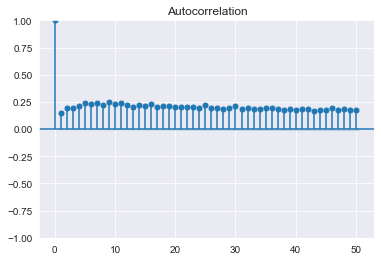

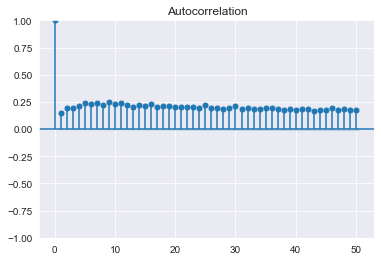

In [65]:
plot_acf(ARIMA_y)

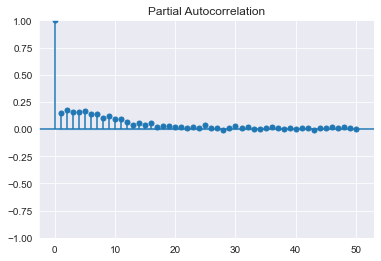

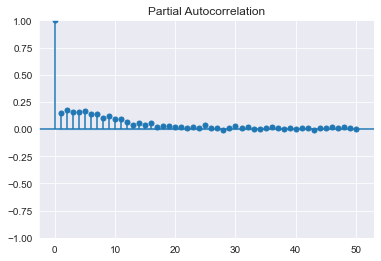

In [66]:
plot_pacf(ARIMA_y)

In [ ]:
ARIMA(y_train, order=(5,1,0)).fit()

In [ ]:
fitted_models = {
    "LSTM": LSTM_model,
    "ARIMA": ARIMA(ARIMA_y, order=(5,1,0)),
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(),
    "XGBoost": xgb.XGBRegressor()
}

# Models evaluation and comparison

In [ ]:
# TODO

# Summary and conclusions

In [ ]:
# TODO